create_regions.ipynb

Creates jackknife regions to be used in the native treecorr jackknife estimator.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('../mpdg.mplstyle')

import fitsio
from fitsio import FITS

from sklearn.cluster import KMeans

def ra_shift(array): #input array of values in degrees

    multiplicative_factors = np.floor(array / 180)
    shifted_array = array - multiplicative_factors * 360

    return shifted_array

In [11]:
lens_bin_directory = '/Users/leo/Projects/mass_profile_dg/data_WL/lenses/KiDS_dwarf_galaxy_candidates_09Aug24_photom'
srce_bin_directory = '/Users/leo/Projects/mass_profile_dg/data_WL/sources/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat'

lens_n_z_directory = '/Users/leo/Projects/mass_profile_dg/data_WL/lenses/n_z_20p5_09Aug24'
srce_n_z_directory = '/Users/leo/Projects/mass_profile_dg/data_WL/KiDS_SOM_N_of_Z'

lens_bin = 3
lenses_per_patch = 200

In [12]:
lens_catalog_path = f'{lens_bin_directory}/KiDS_dwarf_galaxy_bin{lens_bin}.fits'

lens_ra  = fitsio.read(lens_catalog_path, columns = ['ra'])
lens_dec = fitsio.read(lens_catalog_path, columns = ['dec'])
number_of_lenses = len(lens_ra)

In [13]:
field_north = lens_dec['dec'] > -10
field_south = ~field_north

field_north_west = field_north & (lens_ra['ra'] < 150)
field_north_east = field_north & (lens_ra['ra'] > 150)

n_patches_north_west = np.sum(field_north_west)//lenses_per_patch
n_patches_north_east = np.sum(field_north_east)//lenses_per_patch
n_patches_south      = np.sum(field_south)//lenses_per_patch

print('Sources per field')
print(f'KiDS-North-West:\t{np.sum(field_north_west)}')
print(f'\t Patches:\t{n_patches_north_west}')
print(f'\t Lenses/patch:\t{np.sum(field_north_west)/n_patches_north_west:.2f}')
print(f'KiDS-North-East:\t{np.sum(field_north_east)}')
print(f'\t Patches:\t{n_patches_north_east}')
print(f'\t Lenses/patch:\t{np.sum(field_north_east)/n_patches_north_east:.2f}')
print(f'KiDS-South:\t\t{np.sum(field_south)}')
print(f'\t Patches:\t{n_patches_south}')
print(f'\t Lenses/patch:\t{np.sum(field_south)/n_patches_south:.2f}')
print(f'N/S counts ratio:\t{np.sum(field_north)/np.sum(field_south):.2f}')
print(f'Total:\t\t\t{np.sum(field_north_west) + np.sum(field_north_east) + np.sum(field_south)} ({len(lens_dec)})')

Sources per field
KiDS-North-West:	12291
	 Patches:	61
	 Lenses/patch:	201.49
KiDS-North-East:	85997
	 Patches:	429
	 Lenses/patch:	200.46
KiDS-South:		117638
	 Patches:	588
	 Lenses/patch:	200.06
N/S counts ratio:	0.84
Total:			215926 (215926)


In [5]:
lens_all_indices = np.arange(0, len(lens_ra['ra']), 1)

lens_ra_north_west  = lens_ra['ra'][field_north_west]
lens_dec_north_west = lens_dec['dec'][field_north_west]

lens_north_west_indices = lens_all_indices[field_north_west]

clustering_north_west = KMeans(n_clusters = n_patches_north_west, n_init = 'auto').fit(np.c_[lens_ra_north_west, lens_dec_north_west])

lens_ra_north_east  = lens_ra['ra'][field_north_east]
lens_dec_north_east = lens_dec['dec'][field_north_east]

lens_north_east_indices = lens_all_indices[field_north_east]

clustering_north_east = KMeans(n_clusters = n_patches_north_east, n_init = 'auto').fit(np.c_[lens_ra_north_east, lens_dec_north_east])

lens_ra_south  = lens_ra['ra'][field_south]
lens_dec_south = lens_dec['dec'][field_south]

lens_ra_south_shifted = ra_shift(lens_ra_south)

lens_south_indices = lens_all_indices[field_south]

clustering_south = KMeans(n_clusters = n_patches_south, n_init = 'auto').fit(np.c_[lens_ra_south_shifted, lens_dec_south])

cluster_north_west_labels = clustering_north_west.labels_
cluster_north_east_labels = clustering_north_east.labels_ + np.max(cluster_north_west_labels) + 1
cluster_south_labels = clustering_south.labels_ + np.max(cluster_north_east_labels) + 1

cluster_all_labels = np.zeros(len(lens_ra['ra']))
cluster_all_labels[lens_north_west_indices] = cluster_north_west_labels
cluster_all_labels[lens_north_east_indices] = cluster_north_east_labels
cluster_all_labels[lens_south_indices]      = cluster_south_labels
# cluster_all_labels = np.concatenate([cluster_north_west_labels, cluster_north_east_labels, cluster_south_labels])

In [6]:
new_fits_file_path = f'{lens_bin_directory}/KiDS_dwarf_galaxy_bin{lens_bin}_jackknifed.fits'
old_fits_data = fitsio.read(lens_catalog_path)

new_fits_file = FITS(new_fits_file_path, 'rw')

new_fits_file.write(old_fits_data)
new_fits_file[-1].insert_column('jackknife_region', cluster_all_labels)

new_fits_file.close()

In [7]:
res = 0.01

extent_north_west_x_lo = np.min(lens_ra['ra'][field_north_west])
extent_north_west_x_hi = np.max(lens_ra['ra'][field_north_west])
extent_north_west_y_lo = np.min(lens_dec['dec'][field_north_west])
extent_north_west_y_hi = np.max(lens_dec['dec'][field_north_west])

x_NW = np.arange(extent_north_west_x_lo, extent_north_west_x_hi, res)
y_NW = np.arange(extent_north_west_y_lo, extent_north_west_y_hi, res)

xx_NW, yy_NW = np.meshgrid(x_NW, y_NW)
bkg_north_west = clustering_north_west.predict(np.c_[xx_NW.ravel(), yy_NW.ravel()])
bkg_north_west = bkg_north_west.reshape(xx_NW.shape)

In [8]:
res = 0.01

extent_north_east_x_lo = np.min(lens_ra['ra'][field_north_east])
extent_north_east_x_hi = np.max(lens_ra['ra'][field_north_east])
extent_north_east_y_lo = np.min(lens_dec['dec'][field_north_east])
extent_north_east_y_hi = np.max(lens_dec['dec'][field_north_east])

x_NE = np.arange(extent_north_east_x_lo, extent_north_east_x_hi, res)
y_NE = np.arange(extent_north_east_y_lo, extent_north_east_y_hi, res)

xx_NE, yy_NE = np.meshgrid(x_NE, y_NE)
bkg_north_east = clustering_north_east.predict(np.c_[xx_NE.ravel(), yy_NE.ravel()])
bkg_north_east = bkg_north_east.reshape(xx_NE.shape)

In [9]:
res = 0.01

extent_south_shifted_x_lo = np.min(lens_ra_south_shifted)
extent_south_shifted_x_hi = np.max(lens_ra_south_shifted)
extent_south_y_lo = np.min(lens_dec_south)
extent_south_y_hi = np.max(lens_dec_south)

x_S = np.arange(extent_south_shifted_x_lo, extent_south_shifted_x_hi, res)
y_S = np.arange(extent_south_y_lo, extent_south_y_hi, res)

xx_S, yy_S = np.meshgrid(x_S, y_S)
bkg_south = clustering_south.predict(np.c_[xx_S.ravel(), yy_S.ravel()])
bkg_south = bkg_south.reshape(xx_S.shape)

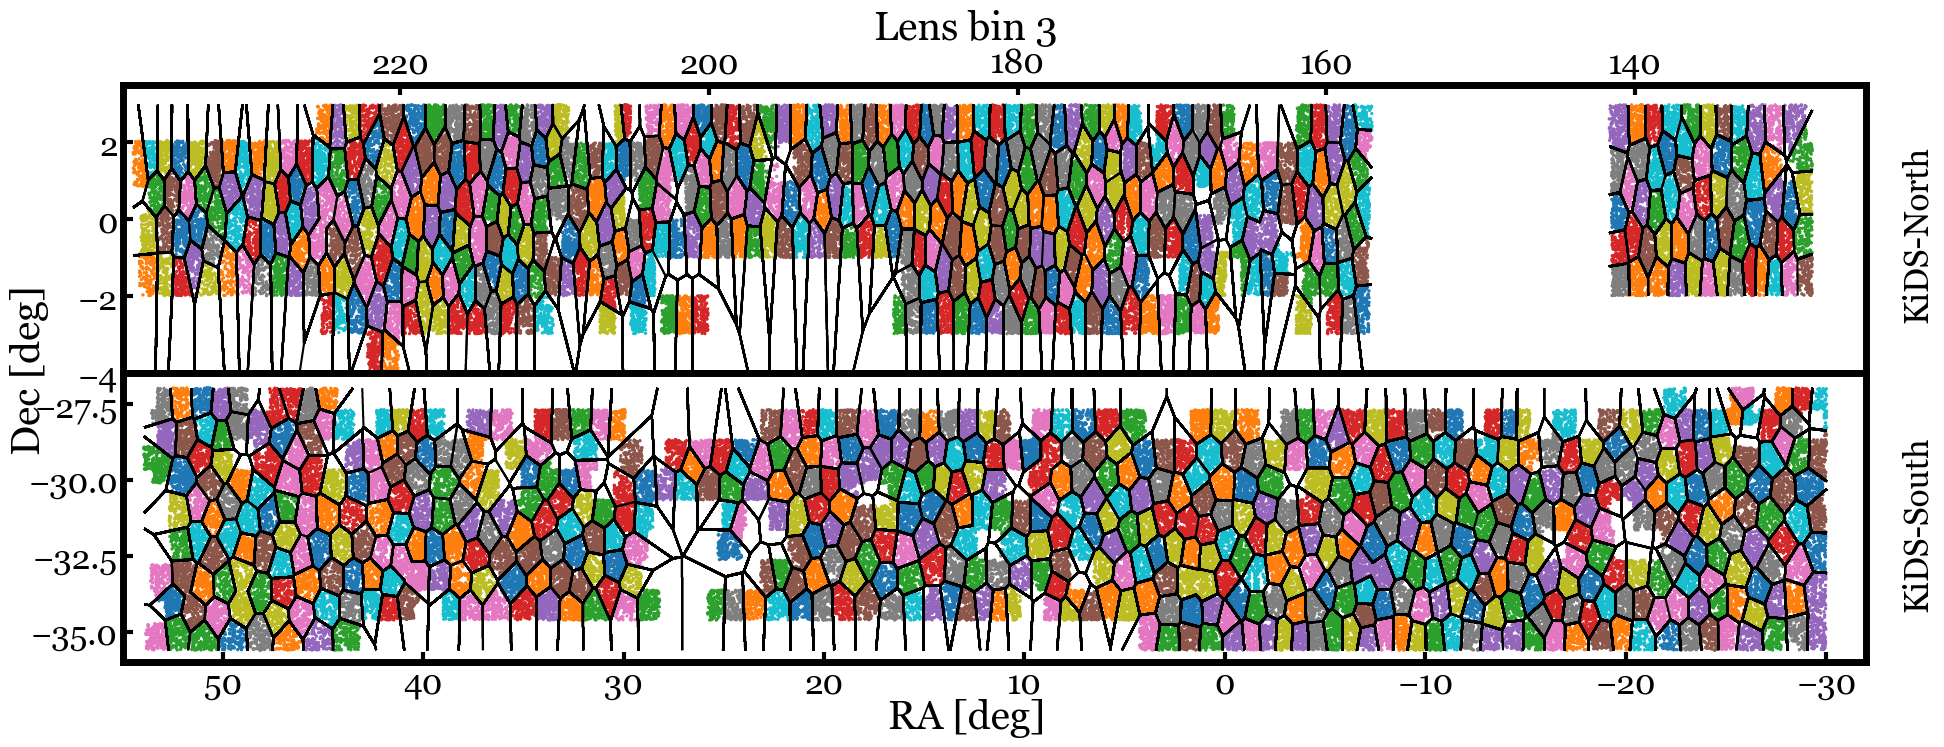

In [10]:
fig = plt.figure(figsize = (22.5, 7.5))

ax_t = fig.add_subplot(211)

cmap = 'tab10'

ax_t.scatter(lens_ra['ra'][field_north_west], lens_dec['dec'][field_north_west], c = cluster_all_labels[field_north_west], s = 2,
             cmap = cmap)
ax_t.scatter(lens_ra['ra'][field_north_east], lens_dec['dec'][field_north_east], c = cluster_all_labels[field_north_east], s = 2,
             cmap = cmap)
# ax_t.scatter(lens_ra_north_east, lens_dec_north_east, c = cluster_north_east_labels, s = 2,
#              cmap = cmap)

ax_t.set_xlim(238, 125)
ax_t.set_ylim(-4, 3.5)

ax_t.text(1.02, 0.2, 'KiDS-North', transform = ax_t.transAxes, rotation = 90)
ax_t.contour(xx_NW, yy_NW, bkg_north_west, colors = ['black'], levels = 100,
             linewidths = 1.5)
ax_t.contour(xx_NE, yy_NE, bkg_north_east, colors = ['black'], levels = 100,
             linewidths = 1.5)

ax_t.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

ax_b = fig.add_subplot(212)

ax_b.scatter(ra_shift(lens_ra['ra'][field_south]), lens_dec['dec'][field_south], c = cluster_all_labels[field_south], s = 2,
             cmap = cmap)
# ax_b.imshow(bkg_south, extent = (extent_south_shifted_x_lo, extent_south_shifted_x_hi,
#                                  extent_south_y_lo, extent_south_y_hi), origin = 'lower')
ax_b.contour(xx_S, yy_S, bkg_south, colors = ['black'], levels = 100,
             linewidths = 1.5)

ax_b.text(1.02, 0.2, 'KiDS-South', transform = ax_b.transAxes, rotation = 90)
ax_b.set_xlim(55, -32)
ax_b.set_ylim(-36, -26.5)

fig.supxlabel('RA [deg]')
fig.supylabel('Dec [deg]', x = .075)

fig.subplots_adjust(hspace = 0)
fig.suptitle(f'Lens bin {lens_bin}')

fig.savefig(f'/Users/leo/Projects/mass_profile_dg/figures/jackknife_regions_lensbin{lens_bin}.pdf', dpi = 150, bbox_inches = 'tight')

___

Old code

In [ ]:
select_indices = (lens_ra['ra'] < 5) & (lens_ra['ra'] > 0) &\
                 (lens_dec['dec'] < -30) & (lens_dec['dec'] > -35)


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
coord_pairs = np.array(list(zip(lens_ra['ra'], lens_dec['dec'])))

In [ ]:
clusters = KMeans(n_clusters = 10).fit(coord_pairs[select_indices])

In [ ]:
x = np.linspace(0, 5, 1000)
y = np.linspace(-30, -35, 1000)

xx, yy = np.meshgrid(x, y)

bkg_colors = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

plt.imshow(bkg_colors.reshape(xx.shape),
           extent = (0, 5, -30, -35))


In [ ]:
bkg_colors = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [ ]:
plt.imshow(bkg_colors.reshape(xx.shape),
           extent = (0, 5, -30, -35))


In [ ]:
patch, area = np.unique(bkg_colors, return_counts = True)

In [ ]:
plt.bar(patch, area)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(bkg_colors.reshape(xx.shape),
           extent = (0, 5, -30, -35), origin = 'lower', alpha = 0.2)
ax.scatter(lens_ra['ra'][select_indices], lens_dec['dec'][select_indices],
           c = clusters.labels_)

In [ ]:
clusters.labels_

In [ ]:
plt.hist(lens_ra['ra'], bins = 'auto')

In [ ]:
plt.hist(lens_dec['dec'], bins = 'auto')

In [ ]:
labels, counts = np.unique(cluster_all_labels, return_counts = True)

In [ ]:
plt.hist(counts, bins = 'auto')

In [ ]:
_, counts = np.unique(cluster_north_labels, return_counts = True)
plt.hist(counts, bins = 'auto')
plt.xlabel('Number of lenses per patch\nin KiDS-North')

In [ ]:
_, counts = np.unique(bkg_north, return_counts = True)
plt.hist(counts * 0.02**2, bins = 'auto')
plt.xlabel('\"Area\" of patch [deg^2]\nin KiDS-North')

In [ ]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot()

ax.scatter(lens_ra['ra'][field_north_west], lens_dec['dec'][field_north_west], c = cluster_all_labels[field_north_west])
# ax.imshow(bkg_north,
#           extent = (extent_north_x_lo, extent_north_x_hi, extent_north_y_lo, extent_north_y_hi),
#           origin = 'lower')
ax.contour(xx_NW, yy_NW, bkg_north_west)

# ax.set_ylim(-5, 5)
# ax.set_xlim(extent_north_x_lo - 5, extent_north_x_hi + 5)
# ax.set_xlim(160, 170)
# ax.set_ylim(-2.5, 2.5)

In [ ]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot()

ax.scatter(lens_ra['ra'][field_north_east], lens_dec['dec'][field_north_east], c = cluster_north_east_labels)
# ax.imshow(bkg_north,
#           extent = (extent_north_x_lo, extent_north_x_hi, extent_north_y_lo, extent_north_y_hi),
#           origin = 'lower')
ax.contour(xx_NE, yy_NE, bkg_north_east)

# ax.set_ylim(-5, 5)
# ax.set_xlim(extent_north_x_lo - 5, extent_north_x_hi + 5)
# ax.set_xlim(160, 170)
# ax.set_ylim(-2.5, 2.5)

In [ ]:
fig = plt.figure(figsize = (40, 5))
ax = fig.add_subplot()

ax.scatter(lens_ra_south_shifted, lens_dec_south, c = cluster_south_labels)
# ax.imshow(bkg_north,
#           extent = (extent_north_x_lo, extent_north_x_hi, extent_north_y_lo, extent_north_y_hi),
#           origin = 'lower')
ax.contour(xx_S, yy_S, bkg_south)

# ax.set_ylim(-5, 5)
# ax.set_xlim(extent_north_x_lo - 5, extent_north_x_hi + 5)
# ax.set_xlim(160, 170)
# ax.set_ylim(-2.5, 2.5)

In [ ]:
fig = plt.figure(figsize = (22.5, 7.5))

ax_t = fig.add_subplot(211)

cmap = 'tab10'

ax_t.scatter(lens_ra_north_west, lens_dec_north_west, c = cluster_north_west_labels, s = 2,
             cmap = cmap)
ax_t.scatter(lens_ra_north_east, lens_dec_north_east, c = cluster_north_east_labels, s = 2,
             cmap = cmap)

ax_t.set_xlim(125, 238)
ax_t.set_ylim(-4, 3.5)

ax_t.text(1.02, 0.2, 'KiDS-North', transform = ax_t.transAxes, rotation = 90)
ax_t.contour(xx_NW, yy_NW, bkg_north_west, colors = ['black'], levels = 100,
             linewidths = 1.5)
ax_t.contour(xx_NE, yy_NE, bkg_north_east, colors = ['black'], levels = 100,
             linewidths = 1.5)

ax_t.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

ax_b = fig.add_subplot(212)

ax_b.scatter(ra_shift(lens_ra_south), lens_dec_south, c = cluster_south_labels, s = 2,
             cmap = cmap)
# ax_b.imshow(bkg_south, extent = (extent_south_shifted_x_lo, extent_south_shifted_x_hi,
#                                  extent_south_y_lo, extent_south_y_hi), origin = 'lower')
ax_b.contour(xx_S, yy_S, bkg_south, colors = ['black'], levels = 100,
             linewidths = 1.5)

ax_b.text(1.02, 0.2, 'KiDS-South', transform = ax_b.transAxes, rotation = 90)
ax_b.set_xlim(-32, 55)
ax_b.set_ylim(-36, -26.5)

fig.supxlabel('RA [deg]')
fig.supylabel('Dec [deg]', x = .075)

fig.subplots_adjust(hspace = 0)